In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from time import time
from tqdm import tqdm
import torchvision.models as models
from collections import Counter
import heapq
from torchaudio.models.decoder import CTCDecoder
from torchaudio.models.decoder import ctc_decoder

In [3]:
root_dir = 'data'
splits = {
    'train': ['train'],
    'valid': ['2014', '2019'],
    'test': ['2016'],
}

class Vocab:
    def __init__(self, vocab_file):
        self.word2index = {}
        self.index2word = {}
        with open(vocab_file, 'r') as f:
            for i, line in enumerate(f):
                word = line.strip()
                if word not in self.word2index:
                    self.word2index[word] = i
                    self.index2word[i] = word

        # Add <blank> at the END if not present
        if '<blank>' not in self.word2index:
            blank_idx = len(self.word2index)
            self.word2index['<blank>'] = blank_idx
            self.index2word[blank_idx] = '<blank>'

        self.index2word[self.word2index['<blank>']] = '<blank>'

    def encode(self, tokens):
        return [self.word2index[tok] for tok in tokens]

    def decode(self, indices):
        return [self.index2word[i] for i in indices]

# Dataset
class CROHMEDatasetWithPaths(Dataset):
    def __init__(self, label_file, vocab, transform=None):
        self.samples = []
        self.vocab = vocab
        self.transform = transform

        with open(label_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 2:
                    continue
                img_path, label = parts
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)

            try:
                label_ids = torch.tensor(self.vocab.encode(label.split()), dtype=torch.long)
            except KeyError as ke:
                print(f"❌ Vocab KeyError in {img_path}: token {ke}")
                return None

            return image, label_ids

        except Exception as e:
            print(f"⚠️ Image load/transform failed for {img_path}: {e}")
            return None




#We need this such that images with varying width will be in the same size in the Dataloder and for visualizing the images
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        print("⚠️ All items in batch were skipped!")
        return None, None, None

    images, labels = zip(*batch)
    image_tensors = torch.stack(images)  # all same size now (HxWxC)
    label_lengths = [len(label) for label in labels]
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    return image_tensors, padded_labels, label_lengths

def visualize_dataset(dataset, vocab, n=5):
    shown = 0
    for i in range(len(dataset)):
        sample = dataset[i]
        if sample is None:
            continue
        image, label_tensor = sample
        label_tokens = vocab.decode(label_tensor.tolist())
        plt.imshow(image.permute(1, 2, 0))  # CHW -> HWC
        plt.title(" ".join(label_tokens))
        plt.axis('off')
        plt.show()
        shown += 1
        if shown >= n:
            break

In [4]:
def build_unified_vocab(root_dir, splits, output_file, exclude_rels=None):
    if exclude_rels is None:
        exclude_rels = ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']

    vocab = set()

    # Collect all caption.txt paths across all splits
    all_label_files = [
        os.path.join(root_dir, subdir, 'caption.txt')
        for dir_list in splits.values()
        for subdir in dir_list
    ]

    # Aggregate all tokens from all caption files
    for label_file in all_label_files:
        with open(label_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 2:
                    continue
                _, label = parts
                tokens = label.strip().split()
                vocab.update(tokens)

    filtered_vocab = sorted(v for v in vocab if v not in exclude_rels)

    with open(output_file, 'w', encoding='utf-8') as out:
        for sym in filtered_vocab:
            out.write(sym + '\n')

    print(f"✅ Unified vocab saved to {output_file} ({len(filtered_vocab)} symbols, excluded: {exclude_rels})")

In [5]:
build_unified_vocab(root_dir, splits, output_file="unified_vocab.txt")

✅ Unified vocab saved to unified_vocab.txt (110 symbols, excluded: ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup'])


In [6]:
unified_vocab = Vocab("unified_vocab.txt")
input = '- \\sqrt 2'.split()
output = [unified_vocab.word2index[word] for word in input]
output #should be (5, 71, 10)

[5, 71, 10]

In [7]:
def create_combined_caption_with_paths(split_dirs, root_dir, output_file):
    with open(output_file, 'w', encoding='utf-8') as out:
        for d in split_dirs:
            caption_path = os.path.join(root_dir, d, 'caption.txt')
            img_dir = os.path.join(root_dir, d, 'img')
            with open(caption_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) != 2:
                        continue
                    img_name, label = parts
                    img_path = os.path.join(img_dir, f"{img_name}.bmp")
                    out.write(f"{img_path}\t{label}\n")

create_combined_caption_with_paths(['train'], root_dir='data', output_file='train_with_paths.txt')
create_combined_caption_with_paths(['2014', '2019'], root_dir='data', output_file='valid_with_paths.txt')
create_combined_caption_with_paths(['2016'], root_dir='data', output_file='test_with_paths.txt')

In [8]:
class ResizeFixedHW:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, img):
        return TF.resize(img, (self.height, self.width))

transform = transforms.Compose([
    ResizeFixedHW(height=32, width=300),  
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
train_dataset = CROHMEDatasetWithPaths(
    label_file='train_with_paths.txt',
    vocab=unified_vocab,
    transform=transform
)

valid_dataset = CROHMEDatasetWithPaths(
    label_file='valid_with_paths.txt',
    vocab=unified_vocab,
    transform=transform
)

test_dataset = CROHMEDatasetWithPaths(
    label_file='test_with_paths.txt',
    vocab=unified_vocab,
    transform=transform
)


In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, collate_fn=collate_fn)

In [11]:
def show_loader_samples(dataloader, vocab, n=5):
    shown = 0
    for batch in dataloader:
        if batch[0] is None:  # skip None batches
            continue
        images, labels, lengths = batch
        for i in range(len(images)):
            img = images[i]
            label = labels[i][:lengths[i]]
            decoded = vocab.decode(label.tolist())

            plt.imshow(img.permute(1, 2, 0))  # CHW to HWC
            plt.axis('off')
            plt.title("GT: " + " ".join(decoded))
            plt.show()

            shown += 1
            if shown >= n:
                return


Train samples:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


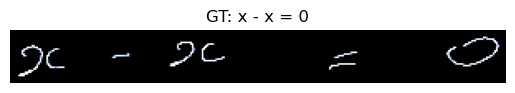

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


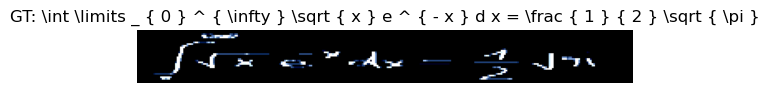

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


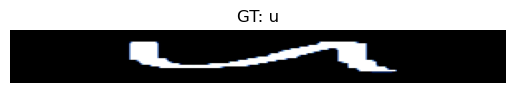

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


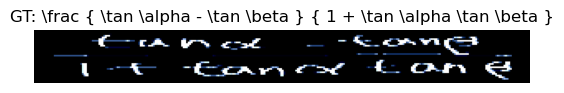

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


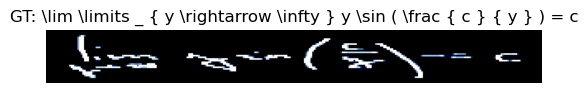

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Valid samples:


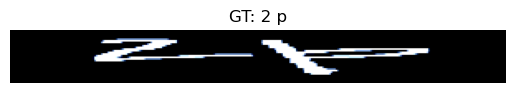

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


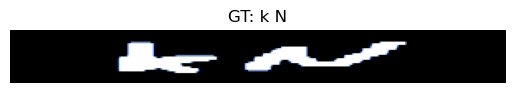

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


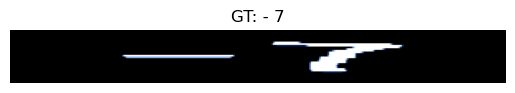

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


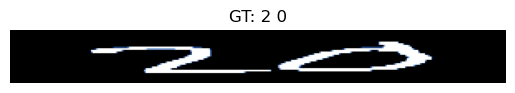

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


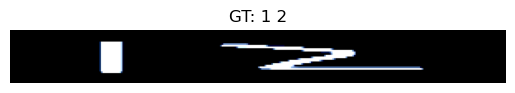

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Test samples:


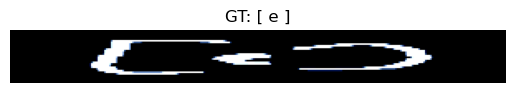

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


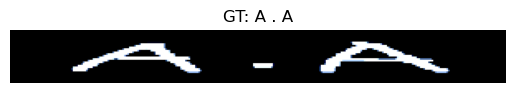

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


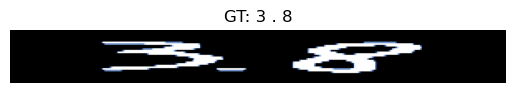

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


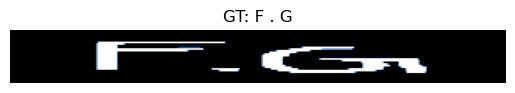

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


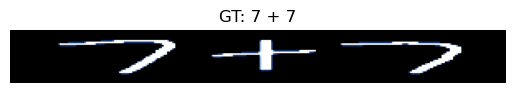

In [12]:
print("Train samples:")
show_loader_samples(train_loader, unified_vocab)

print("Valid samples:")
show_loader_samples(valid_loader, unified_vocab)

print("Test samples:")
show_loader_samples(test_loader, unified_vocab)

In [13]:
def show_loader_samples(dataloader, vocab, n=5, m=1, preds=None):
    """
    Show `n` images from dataloader arranged in `m` rows.
    If `preds` is provided, display both GT and predicted labels.
    """
    images_to_show = []
    titles = []

    shown = 0
    for batch in dataloader:
        if batch[0] is None:
            continue
        images, labels, lengths = batch
        for i in range(len(images)):
            img = images[i]
            label = labels[i][:lengths[i]]
            decoded_gt = vocab.decode(label.tolist())
            title = "GT: " + " ".join(decoded_gt)

            if preds is not None and shown < len(preds):
                decoded_pred = preds[shown]
                title += "\nPred: " + " ".join(decoded_pred)

            images_to_show.append(img)
            titles.append(title)

            shown += 1
            if shown >= n:
                break
        if shown >= n:
            break

    # Grid setup
    rows = m
    cols = math.ceil(n / m)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # Normalize axes to 2D array
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    idx = 0
    for i in range(rows):
        for j in range(cols):
            ax = axes[i][j] if rows > 1 else axes[0][j]
            if idx < len(images_to_show):
                img = images_to_show[idx].permute(1, 2, 0)
                ax.imshow(img)
                ax.set_title(titles[idx], fontsize=8)
                ax.axis('off')
                idx += 1
            else:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


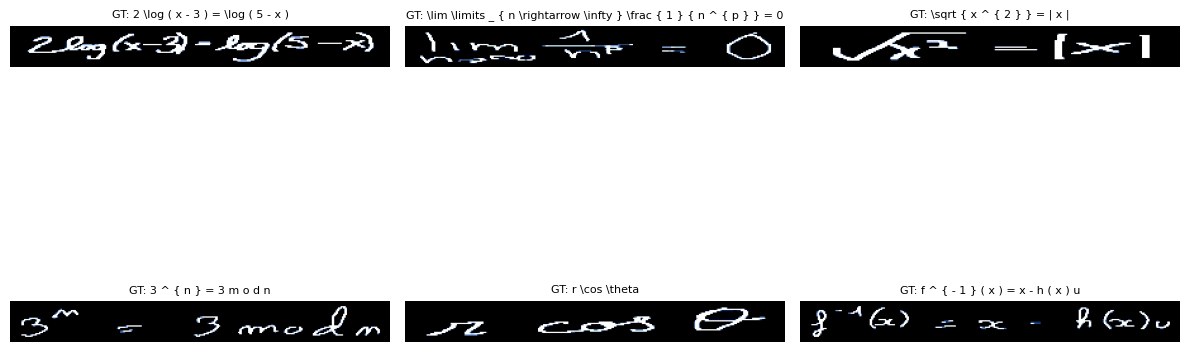

In [14]:
import math
# Assume preds is a list like: [["2", "+", "x"], ["y", "=", "3"], ...]
show_loader_samples(train_loader, unified_vocab, n=6, m=2, preds=None)


In [15]:
def count_valid_samples(dataloader, name):
    total = 0
    skipped_batches = 0

    for batch in dataloader:
        if batch[0] is None:  # skip bad batch
            skipped_batches += 1
            continue
        images, _, _ = batch
        total += images.size(0)

    print(f"✅ {name.capitalize()} Loader contains {total} valid samples")
    if skipped_batches > 0:
        print(f"⚠️  {skipped_batches} batch(es) were skipped due to oversized or invalid images")
    return total

train_count = count_valid_samples(train_loader, 'train')
valid_count = count_valid_samples(valid_loader, 'valid')
test_count  = count_valid_samples(test_loader, 'test')


✅ Train Loader contains 8834 valid samples
✅ Valid Loader contains 2185 valid samples
✅ Test Loader contains 1147 valid samples


In [16]:
# Function to compute Levenshtein Distance (used for WER and CER)
def levenshtein_distance(a, b):
    m = len(a) + 1
    n = len(b) + 1
    dp = np.zeros((m, n))
    
    for i in range(m):
        dp[i][0] = i
    for j in range(n):
        dp[0][j] = j
    
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    
    return dp[m - 1][n - 1]


# Function to calculate Word Error Rate (WER)
def compute_wer(predictions, labels):
    total_words = sum(len(label.split()) for label in labels)
    errors = 0
    for pred, label in zip(predictions, labels):
        errors += levenshtein_distance(pred.split(), label.split())  # Calculate WER at word level
    return errors / total_words if total_words > 0 else 0


# Function to calculate Character Error Rate (CER)
def compute_cer(predictions, labels):
    total_chars = sum(len(label) for label in labels)
    errors = 0
    for pred, label in zip(predictions, labels):
        errors += levenshtein_distance(list(pred), list(label))  # Calculate CER at character level
    return errors / total_chars if total_chars > 0 else 0

class CRNN(nn.Module):
    def __init__(self, num_classes, img_size=(3, 32, 300)):
        super(CRNN, self).__init__()

        # Load pretrained VGG16 and keep convolutional part only
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        features = list(vgg.features.children())

        # Keep layers up to conv5_3 (before final MaxPool and FC)
        # This retains a high enough spatial resolution (especially width)
        self.cnn = nn.Sequential(*features[:33])  # includes conv5_3 and relu5_3

        # Infer the size of the feature map to reshape for RNN input
        with torch.no_grad():
            dummy = torch.zeros(1, 3, *img_size[1:])  # e.g., (1, 3, 32, 300)
            feat = self.cnn(dummy)
            _, C, H, W = feat.shape
            self.rnn_input_size = C*H
        
        print(f"VGG CNN Output Shape: (C={C}, H={H}, W={W}) → RNN input size: {C*H}")

        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=256,
            num_layers=2,
            dropout=0.5,
            bidirectional=True,
            batch_first=True
        )

        self.norm = nn.LayerNorm(512)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # (B, C, H, W)
        x = x.permute(0, 3, 1, 2)  # (B, W, C, H)
        B, W, C, H = x.size()
        x = x.reshape(B, W, C*H)  # (B, W, C*H)

        x, _ = self.rnn(x)
        x = self.norm(x)
        x = self.dropout_fc(x)
        x = self.fc(x)  # (B, W, num_classes)
        return x



# # Model Definition (CRNN class)
# class CRNN(nn.Module):
#     def __init__(self, num_classes, img_size=(3, 32, 300)):
#         super(CRNN, self).__init__()
#         resnet = models.resnet18(weights=None)
#         state_dict = torch.load("resnet18-f37072fd.pth")
#         resnet.load_state_dict(state_dict)


#         #For freezing layers 
#         # for param in list(resnet.children())[:3]:
#         #     for p in param.parameters():
#         #         p.requires_grad = False

#         #Unfreeze deeper layers (e.g., layer1 and on)
#         # for param in list(resnet.children())[3:]:
#         #     for p in param.parameters():
#         #         p.requires_grad = True

#         # Extract CNN layers up to layer3
#         self.cnn = nn.Sequential(
#             *list(resnet.children())[:-3],                # Keep until layer3
#             nn.BatchNorm2d(256),                          # Add BatchNorm after last conv layer
#             nn.Dropout2d(p=0.3)                           # Dropout after batchnorm
#         )

#         # Infer feature‐map size
#         with torch.no_grad():
#             dummy = torch.zeros(1, 3, 32, 100)  # Match ResizeFixedHW(height=32, width=100)
#             feat = self.cnn(dummy)          # (1, C, H, W)
#             _, C, H, W = feat.shape
            
#         # Bidirectional LSTM with dropout
#         self.rnn = nn.LSTM(
#             input_size=C*H,
#             hidden_size=256,
#             num_layers=2,
#             dropout=0.5,              # Dropout between LSTM layers
#             bidirectional=True,
#             batch_first=True
#         )
#         self.norm = nn.LayerNorm(512)
#         self.dropout_fc = nn.Dropout(p=0.3)              # Dropout before final classification
#         self.fc = nn.Linear(512, num_classes)

#     def forward(self, x):
        
#         # x = self.cnn(x)  # (B, 256, H, W)
#         # x = nn.functional.adaptive_avg_pool2d(x, (1, x.size(3)))  # (B, 256, 1, W)
#         # x = x.squeeze(2)  # (B, 256, W)
#         # x = x.permute(0, 2, 1)  # (B, W, 256)

#         #CRNN Paper Implementation
        
#         x = self.cnn(x)  # (B, C, H, W)
#         # Permute to (B, W, C, H) so each column becomes a sequence frame
#         x = x.permute(0, 3, 1, 2)  # (B, W, C, H)
#         # Flatten height and channel into a single feature vector per time step
#         B, W, C, H = x.size()
#         x = x.reshape(B, W, C * H)  # (B, W, C*H)
        
#         x, _ = self.rnn(x)
#         x = self.norm(x)
#         x = self.dropout_fc(x)
#         x = self.fc(x)
#         return x



In [17]:
tokens = [unified_vocab.index2word[i] for i in range(len(unified_vocab.index2word))]
blank_token = '<blank>'

beam_search_decoder = ctc_decoder(
    tokens=tokens,
    lexicon=None,                     # Set this to list of valid sequences if using one
    lm=None,                          # Optional KenLM .arpa file if you have it
    nbest=1,
    beam_size=50,
    lm_weight=0.5,
    word_score=1.0,
    blank_token=blank_token
)

In [18]:
# Training Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CRNN(num_classes=len(unified_vocab.word2index)).to(device)
criterion = nn.CTCLoss(blank=unified_vocab.word2index['<blank>'], zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# optimizer = torch.optim.Adam([
#     {'params': model.cnn.parameters(), 'lr': 1e-5},   # slow learning for CNN
#     {'params': model.rnn.parameters(), 'lr': 1e-4},   # normal for LSTM
#     {'params': model.fc.parameters(),  'lr': 1e-4}
# ])

# Add this:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Minimize the validation loss
    factor=0.5,         # Reduce LR by a factor of 0.5
    patience=2,         # Wait for 2 epochs before reducing LR
    verbose=True        # Print LR updates
)

for name, param in model.named_parameters():
    print(f"{name:40s}  requires_grad={param.requires_grad}")

train_losses = []
val_losses = []
train_wer = []
val_wer = []
train_cer = []
val_cer = []

# def decode(output, vocab):
#     preds = output.argmax(dim=-1)  # (B, T)
#     decoded = []
#     for pred in preds:
#         tokens = []
#         prev = -1
#         for p in pred:
#             if p != prev and p != vocab.word2index['<blank>']:
#                 tokens.append(vocab.index2word[p.item()])
#             prev = p
#         decoded.append(" ".join(tokens))
#     return decoded

# # beam_decoder = CTCBeamDecoder(
# #     labels=[unified_vocab.index2word[i] for i in range(len(unified_vocab.index2word))],
# #     blank_id=unified_vocab.word2index['<blank>'],
# #     beam_width=10,
# #     num_processes=4,
# #     log_probs_input=True  # important: pass in log-softmax output
# # )

# def decode_beam(output, vocab):
#     # Output: (T, B, C) — C = num_classes
#     output_log_probs = torch.nn.functional.log_softmax(output, dim=-1)

#     # Decode: output shape should be (B, T, C)
#     output_log_probs = output_log_probs.permute(1, 0, 2).cpu()

#     beam_results, _, _, out_lens = beam_decoder.decode(output_log_probs)

#     decoded = []
#     for i, length in enumerate(out_lens):
#         tokens = [beam_results[i][0][j].item() for j in range(length[0])]
#         decoded.append(" ".join(vocab.index2word[t] for t in tokens))
#     return decoded
    
num_epochs = 60
best_val_loss = float('inf')

resume_training = False 
checkpoint_path = 'crnn_checkpoint.pth'

start_epoch = 0
best_val_loss = float('inf')

if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('val_loss', float('inf'))  # Optional: track best loss
    print(f"Resumed training from epoch {start_epoch} (best val loss so far: {best_val_loss:.4f})")
else:
    print("Starting fresh training.")

total_epoch = 50



VGG CNN Output Shape: (C=512, H=4, W=37) → RNN input size: 2048
cnn.0.weight                              requires_grad=True
cnn.0.bias                                requires_grad=True
cnn.1.weight                              requires_grad=True
cnn.1.bias                                requires_grad=True
cnn.3.weight                              requires_grad=True
cnn.3.bias                                requires_grad=True
cnn.4.weight                              requires_grad=True
cnn.4.bias                                requires_grad=True
cnn.7.weight                              requires_grad=True
cnn.7.bias                                requires_grad=True
cnn.8.weight                              requires_grad=True
cnn.8.bias                                requires_grad=True
cnn.10.weight                             requires_grad=True
cnn.10.bias                               requires_grad=True
cnn.11.weight                             requires_grad=True
cnn.11.bias          

/opt/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(total_epoch):
    start_time = time()
    model.train()
    epoch_train_loss = 0
    epoch_train_preds = []
    epoch_train_labels = []

    pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels, label_lengths in pbar:
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = torch.tensor(label_lengths, dtype=torch.long, device=device)

        output = model(images)
        output = output.permute(1, 0, 2)
        input_lengths = torch.full(
                        size=(output.size(1),),
                        fill_value=output.size(0),
                        dtype=torch.long
                    )

        # length_weights = label_lengths.float() / label_lengths.max()
        loss = criterion(output, labels, input_lengths, label_lengths)
        # loss = loss * length_weights.mean()  # Or .sum() if you want total impact scaled
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_train_loss += loss.item()

        pbar.set_postfix(train_loss=loss.item())

        # Decode predictions and accumulate for WER/CER calculation
        log_probs = torch.nn.functional.log_softmax(output.detach(), dim=-1)  # (T, B, C)
        log_probs = log_probs.permute(1, 0, 2).cpu()  # (B, T, C)
        beam_out = beam_search_decoder(log_probs.contiguous())
        preds=[]

        for hyp in beam_out:
            top = hyp[0]
            tokens_out = [idx for idx in top.tokens if idx != unified_vocab.word2index['<blank>']]
            words = [unified_vocab.index2word[idx.item()] for idx in tokens_out]
            preds.append(" ".join(words))

        labels_decoded = []
        for lbl in labels:
            tokens = [unified_vocab.index2word[l.item()] for l in lbl if l.item() != unified_vocab.word2index['<blank>']]
            labels_decoded.append(" ".join(tokens))
        epoch_train_preds.extend(preds)
        epoch_train_labels.extend(labels_decoded)

    # Compute Train WER and CER
    train_wer.append(compute_wer(epoch_train_preds, epoch_train_labels))
    train_cer.append(compute_cer(epoch_train_preds, epoch_train_labels))

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    epoch_time = time() - start_time

    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        pbar_val = tqdm(valid_loader, desc=f"[Epoch {epoch+1}] Validating", leave=False)
        for images, labels, label_lengths in pbar_val:
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = torch.tensor(label_lengths, dtype=torch.long)

            output = model(images)
            output = output.permute(1, 0, 2)
            input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)

            val_loss = criterion(output, labels, input_lengths, label_lengths)
            epoch_val_loss += val_loss.item()

            pbar_val.set_postfix(val_loss=val_loss.item())

            # Decode predictions and accumulate for WER/CER calculation
            # preds = decode(output, unified_vocab)

            log_probs = torch.nn.functional.log_softmax(output.detach(), dim=-1)
            log_probs = log_probs.permute(1, 0, 2).cpu()
            beam_out = beam_search_decoder(log_probs.contiguous())

            preds = []
            for hyp in beam_out:
                top = hyp[0]  # Best hypothesis
                tokens_out = [idx for idx in top.tokens if idx != unified_vocab.word2index['<blank>']]
                words = [unified_vocab.index2word[idx.item()] for idx in tokens_out]
                preds.append(" ".join(words))
            
            epoch_val_preds.extend(preds)

            labels_decoded = []
            for i in range(len(labels)):
                label_seq = labels[i][:label_lengths[i]]
                tokens = [unified_vocab.index2word[l.item()] for l in label_seq if l.item() != unified_vocab.word2index['<blank>']]
                labels_decoded.append(" ".join(tokens))

            epoch_val_labels.extend(labels_decoded)


        # 🔍 Add granular error logging here
        length_bins = {}
        token_confusions = {}

        for pred, true in zip(epoch_val_preds, epoch_val_labels):
            pred_tokens = pred.split()
            true_tokens = true.split()

            length = len(true_tokens)
            bin_key = f"len={length}"
            error = levenshtein_distance(pred.replace(" ", ""), true.replace(" ", ""))

            if bin_key not in length_bins:
                length_bins[bin_key] = []
            length_bins[bin_key].append(error)

            for t_pred, t_true in zip(pred_tokens, true_tokens):
                if t_pred != t_true:
                    key = (t_true, t_pred)
                    token_confusions[key] = token_confusions.get(key, 0) + 1

    print("\n📊 Avg Levenshtein Error by Length:")
    for k in sorted(length_bins.keys(), key=lambda x: int(x.split('=')[1])):
        avg_err = sum(length_bins[k]) / len(length_bins[k])
        print(f"{k}: {avg_err:.2f}")

    print("\n🤯 Top Token Confusions:")
    for (true_tok, pred_tok), count in sorted(token_confusions.items(), key=lambda x: -x[1])[:10]:
        print(f"GT: {true_tok:10s} → Pred: {pred_tok:10s} ({count} times)")


    avg_val_loss = epoch_val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Compute Validation WER and CER
    val_wer.append(compute_wer(epoch_val_preds, epoch_val_labels))
    val_cer.append(compute_cer(epoch_val_preds, epoch_val_labels))

    print("\n🧠 Prediction Length Analysis (Val Set)")
    for pred, true in zip(epoch_val_preds[:20], epoch_val_labels[:20]):
        print(f"GT length: {len(true.split()):2d}, Pred length: {len(pred.split()):2d}")

    print(f"\n Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s — "
      f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
      f"Train WER: {train_wer[-1]:.4f}, Val WER: {val_wer[-1]:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, 'crnn_best_model.pth')
        print("💾 Best model saved.")

    torch.save({
    'epoch': epoch + 1,  # next epoch to resume from
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "crnn_checkpoint.pth")
        
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train WER: {train_wer[-1]:.4f} | Val WER: {val_wer[-1]:.4f} | Val CER: {val_cer[-1]:.4f}")

    
# Plotting Loss and Accuracy Metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_wer, label='Train WER', marker='o')
plt.plot(val_wer, label='Validation WER', marker='o')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.title('Train vs Validation WER')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("crnn_training_metrics.png")
plt.show()


[Epoch 1/60] Training:   1%|          | 1/139 [00:10<24:31, 10.66s/it, train_loss=-2.9]

Addressing the usage of '|' as a blank token, which in CTC decoding is often inserted at the start and end to allow for variable-length alignment

In [19]:
# --- Step 1: Remove duplicates safely ---
corrected_index2word = {}
seen = set()

for idx, token in unified_vocab.index2word.items():
    if token not in seen:
        corrected_index2word[idx] = token
        seen.add(token)
    else:
        corrected_index2word[idx] = f"{token}_{idx}"  # e.g., '|_50', '|_78'

# ✅ Ensure only ONE <blank>
# Find the correct index of <blank>
blank_indices = [idx for idx, tok in corrected_index2word.items() if tok == '<blank>']
if len(blank_indices) > 1:
    # Keep the first, remove the rest
    first_idx = blank_indices[0]
    for idx in blank_indices[1:]:
        corrected_index2word[idx] = f"<blank>_{idx}"

# Update vocab
unified_vocab.index2word = corrected_index2word
unified_vocab.word2index = {v: k for k, v in corrected_index2word.items()}

tokens = [unified_vocab.index2word[i] for i in range(len(unified_vocab.index2word))]

beam_search_decoder = ctc_decoder(
    tokens=tokens,
    lexicon=None,
    lm=None,
    nbest=1,
    beam_size=50,
    lm_weight=0.5,
    word_score=1.0,
    blank_token='<blank>'
)


In [20]:
def collapse_repeats(tokens):
    collapsed = []
    prev = None
    for token in tokens:
        if token != prev:
            collapsed.append(token)
        prev = token
    return collapsed

def collect_predictions(model, dataloader, vocab, device):
    entries = []
    model.eval()

    with torch.no_grad():
        for images, labels_batch, lengths in dataloader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            lengths = torch.tensor(lengths, dtype=torch.long, device=device)

            output = model(images).permute(1, 0, 2)  # (T, B, C)

            input_lengths = torch.full(
                size=(output.size(1),), fill_value=output.size(0),
                dtype=torch.long, device=device
            )

            # Softmax to get probabilities
            probs = torch.nn.functional.softmax(output, dim=-1)  # (T, B, C)

            output = output.permute(1, 0, 2)  # (B, T, C) needed for beam_search_decoder
            probs = probs.permute(1, 0, 2)    # (B, T, C) as well

            results = beam_search_decoder(output, input_lengths)

            preds = []

            for b_idx, result in enumerate(results):
                hypothesis = result[0]
                token_ids = hypothesis.tokens  # tensor([t1, t2, t3])

                # Step 0: Decode token ids
                pred_tokens = [vocab.index2word[idx.item()] for idx in token_ids]

                # Step 1: Remove <blank>
                pred_tokens = [tok for tok in pred_tokens if tok != '<blank>']

                # Step 2: Clean '|_110' → '|'
                pred_tokens = [tok.split('_')[0] for tok in pred_tokens]

                # Step 3: (Optional) collapse repeated tokens if adjacent are the same
                pred_tokens = collapse_repeats(pred_tokens)

                # Step 4: Strip leading and trailing '|'
                while pred_tokens and pred_tokens[0] == '|':
                    pred_tokens.pop(0)
                while pred_tokens and pred_tokens[-1] == '|':
                    pred_tokens.pop(-1)

                # Step 5: Collect confidence for each token
                token_confidences = []
                sample_probs = probs[b_idx]  # (T, C)

                for t_idx in hypothesis.timesteps:  # timesteps where tokens were selected
                    t_idx = t_idx.item()
                    if 0 <= t_idx < sample_probs.shape[0]:
                        token_id = token_ids[hypothesis.timesteps == t_idx][0].item()
                        token_conf = sample_probs[t_idx, token_id].item()
                        token_confidences.append(token_conf)
                    else:
                        token_confidences.append(0.0)  # fallback if index bad

                preds.append((pred_tokens, token_confidences))

            for img_tensor, (pred_tokens, pred_confs), lbl, L in zip(images.cpu(), preds, labels_batch, lengths):
                true_tokens = [vocab.index2word[idx.item()] for idx in lbl[:L]]
                true_tokens = [tok for tok in true_tokens if tok != '<blank>']

                true = " ".join(true_tokens)
                pred = " ".join(pred_tokens)

                err = levenshtein_distance(pred.replace(" ", ""), true.replace(" ", ""))

                # Save entry with confidences
                entries.append((img_tensor, true, pred, err, pred_confs))

    return entries



In [21]:
# === Step 2: Sort and Select ===

def get_best_and_worst(entries, top_k=10):
    sorted_entries = sorted(entries, key=lambda x: x[3])
    return sorted_entries[:top_k], sorted_entries[-top_k:]

# === Step 3: Plot ===

def plot_predictions(samples, title, max_tokens=40):
    fig, axes = plt.subplots(1, len(samples), figsize=(3.5 * len(samples), 4))
    if len(samples) == 1:
        axes = [axes]  # Handle single image case

    for ax, sample in zip(axes, samples):
        if len(sample) == 5:
            img, true, pred, err, probs = sample
        else:
            img, true, pred, err = sample
            probs = None

        img_np = img.permute(1, 2, 0).numpy()
        cmap = 'gray' if img_np.ndim == 2 or img_np.shape[2] == 1 else None
        ax.imshow(img_np.squeeze(), cmap=cmap, vmin=0, vmax=1)

        def truncate(s, max_len=max_tokens):
            return s if len(s) <= max_len else s[:max_len] + "..."

        # New: add probs in the title if available
        subtitle = f"Err={int(err)}\nGT:{truncate(true)}\nPR:{truncate(pred)}"

        ax.set_title(subtitle, fontsize=8)
        ax.axis('off')

        print(f"\n🔍 Full GT:   {true}")
        print(f"🔮 Full Pred: {pred}")
        print(f"✏️  Error:    {err}")
        if probs is not None:
            print(f"🔮 Token Confidences: {[f'{p:.2f}' for p in probs]}")

    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

In [22]:
# Use the exact CRNN definition and img_size from training
model = CRNN(num_classes=len(unified_vocab.word2index)).to(device)
checkpoint = torch.load('crnn_best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

VGG CNN Output Shape: (C=512, H=4, W=37) → RNN input size: 2048


CRNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, ke

In [23]:
# Step 1: Collect predictions
entries = collect_predictions(model, valid_loader, unified_vocab, device)

In [24]:
test_entries = collect_predictions(model, test_loader, unified_vocab, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].



🔍 Full GT:   A . A
🔮 Full Pred: A . A
✏️  Error:    0.0
🔮 Token Confidences: ['0.00', '0.02', '0.01', '0.00', '0.00']

🔍 Full GT:   3 . 8
🔮 Full Pred: 3 . 8
✏️  Error:    0.0
🔮 Token Confidences: ['0.00', '0.08', '0.08', '0.01', '0.00']

🔍 Full GT:   F . G
🔮 Full Pred: F . G
✏️  Error:    0.0
🔮 Token Confidences: ['0.00', '0.01', '0.00', '0.00', '0.00']

🔍 Full GT:   7 + 7
🔮 Full Pred: 7 + 7
✏️  Error:    0.0
🔮 Token Confidences: ['0.00', '0.10', '0.00', '0.00', '0.00']


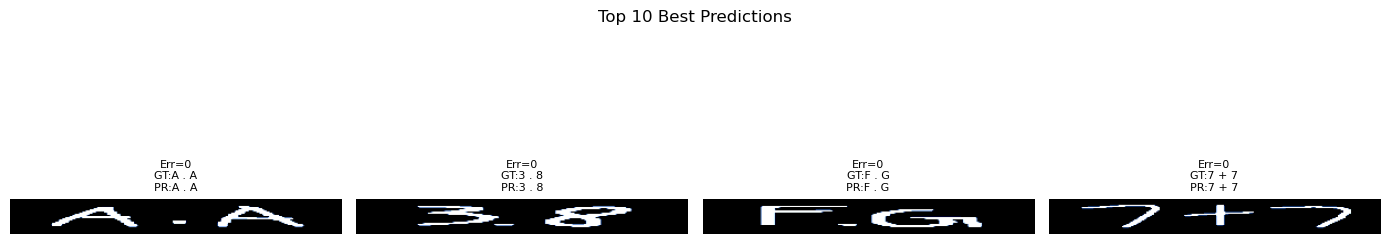

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].



🔍 Full GT:   N _ { 2 1 } ( x , y , a ) = - \frac { 1 } { 8 a y } \sum \limits _ { n = 1 } ^ { \infty } \cos ( \frac { 2 n \pi x } { a } ) e ^ { - \frac { 2 n \pi y } { a } }
🔮 Full Pred: u  { } ( ) = { 1 } { ( { } { } { }
✏️  Error:    81.0
🔮 Token Confidences: ['0.01', '0.00', '0.00', '0.00', '0.27', '0.15', '0.10', '0.39', '0.32', '0.09', '0.37', '0.08', '0.22', '0.38', '0.39', '0.42', '0.32', '0.01', '0.00', '0.00']

🔍 Full GT:   z = ( \sin \frac { 1 } { 2 } \theta _ { 1 2 } \sin \frac { 1 } { 2 } \theta _ { 3 4 } ) / ( \sin \frac { 1 } { 2 } \theta _ { 1 3 } \sin \frac { 1 } { 2 } \theta _ { 2 4 } )
🔮 Full Pred: \frac { } + } { } { } { } ) { } { } { 2 }
✏️  Error:    89.0
🔮 Token Confidences: ['0.00', '0.19', '0.39', '0.27', '0.12', '0.33', '0.26', '0.25', '0.19', '0.15', '0.04', '0.18', '0.41', '0.11', '0.25', '0.15', '0.25', '0.22', '0.57', '0.64', '0.00']

🔍 Full GT:   y ^ { a } = \{ r \cos \theta _ { 1 } , \ldots , r \sin \theta _ { 1 } \ldots \cos \theta _ { d - 1 } , r \sin 

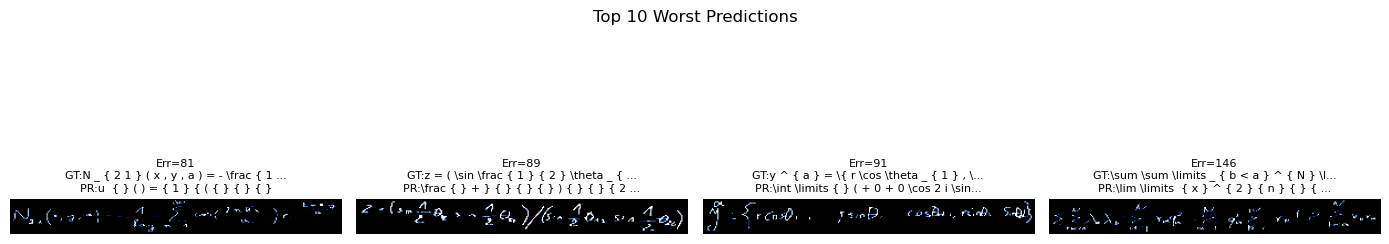

In [25]:
# Step 2: Get best and worst samples
best_samples, worst_samples = get_best_and_worst(test_entries, top_k=4)

# Step 3: Plot the best predictions
plot_predictions(best_samples, title="Top 10 Best Predictions")

# Step 4: Plot the worst predictions
plot_predictions(worst_samples, title="Top 10 Worst Predictions")


In [26]:
def select_diverse_error_samples(entries, n, max_label_length=40):
    """
    Select n entries evenly spread across the error spectrum, ensuring label lengths are within limits.
    """
    # Filter out long-label samples first
    filtered_entries = [
        entry for entry in entries
        if len(entry[1]) <= max_label_length and len(entry[2]) <= max_label_length
    ]

    if len(filtered_entries) < n:
        print(f"⚠️ Only {len(filtered_entries)} entries found with short enough labels (needed {n})")
        return filtered_entries  # fallback to whatever we have

    sorted_entries = sorted(filtered_entries, key=lambda x: x[3])
    indices = np.linspace(0, len(sorted_entries) - 1, n, dtype=int)
    return [sorted_entries[i] for i in indices]

def preprocess_for_display(img_tensor, upsample_size=(300, 500)):
    # Resize image to a fixed shape for consistency
    img = F.interpolate(img_tensor.unsqueeze(0), size=upsample_size, mode='bilinear', align_corners=False).squeeze(0)

    # Stretch contrast (normalize min/max)
    img_min = img.min()
    img_max = img.max()
    if img_max > img_min:
        img = (img - img_min) / (img_max - img_min)
    return img

def plot_grid_of_predictions(samples, title, max_tokens=40, max_label_length=40, ncols=6, upsample_size=(300, 500)):
    # Step 1: Filter out too-long label samples first
    filtered = [
        sample for sample in samples
        if len(sample[1]) <= max_label_length and len(sample[2]) <= max_label_length
    ]

    # Step 2: Only keep the first N filtered samples
    desired_n = len(samples)
    filtered_samples = filtered[:desired_n]

    n = len(filtered_samples)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 3.5))
    axes = axes.flatten()

    for idx in range(nrows * ncols):
        ax = axes[idx]
        if idx >= n:
            ax.axis('off')
            continue

        sample = filtered_samples[idx]
        img, true, pred, err = sample[:4]
        probs = sample[4] if len(sample) == 5 else None

        img_proc = preprocess_for_display(img, upsample_size)
        img_np = img_proc.permute(1, 2, 0).numpy()
        cmap = 'gray' if img_np.shape[2] == 1 else None

        ax.imshow(img_np.squeeze(), cmap=cmap, vmin=0, vmax=1)
        ax.set_title(f"Err={int(err)}\nGT:{true}\nPR:{pred}", fontsize=10, fontweight='bold')
        ax.axis('off')

        print(f"\n🔍 GT:   {true}")
        print(f"🔮 PR:   {pred}")
        print(f"✏️  Err: {err}")

    plt.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.05, wspace=0.05, hspace=0.35)
    plt.suptitle(title, fontsize=20)
    plt.show()



🔍 GT:   2 p
🔮 PR:   2 p
✏️  Err: 0.0

🔍 GT:   0 . 0 8 7 8
🔮 PR:   0 . 0 8 7 8
✏️  Err: 0.0

🔍 GT:   \sqrt { - n } = i \sqrt { n }
🔮 PR:   \sqrt { - n } = i \sqrt { n }
✏️  Err: 0.0

🔍 GT:   \cos ( m y )
🔮 PR:   \cos ( m y )
✏️  Err: 0.0

🔍 GT:   3 + 7 + 1 2 7 = 1 3 7
🔮 PR:   3 + 7 + 1 2 7 = 1 3 7
✏️  Err: 0.0

🔍 GT:   6 7 7 8
🔮 PR:   6 7 8
✏️  Err: 1.0

🔍 GT:   ( \sqrt { 2 } x + 2 ) ( x + 3 )
🔮 PR:   ( \sqrt { 2 } x + 2 ) ( x + )
✏️  Err: 1.0

🔍 GT:   X \times X \times X
🔮 PR:   x \times X \times X
✏️  Err: 1.0

🔍 GT:   \log
🔮 PR:   \log e g
✏️  Err: 2.0

🔍 GT:   \frac { 1 } { c }
🔮 PR:   \frac { } { }
✏️  Err: 2.0

🔍 GT:   \mu \geq 0
🔮 PR:   M \geq 0
✏️  Err: 3.0

🔍 GT:   1 . 0 7 3 7 + 1 . 2 2 2 7
🔮 PR:   1 0 7 3 7 + 1 . 2 7
✏️  Err: 3.0

🔍 GT:   n \log n
🔮 PR:   n ( 0 n
✏️  Err: 4.0

🔍 GT:   x ^ { 2 } + 5 / 6 x + 1 / 6
🔮 PR:   x ^ { 2 } + 5  { b } x + 1 { 6 }
✏️  Err: 5.0

🔍 GT:   \sin ( \theta ) + i \cos ( \theta )
🔮 PR:   \sin ( s ) + i \cos ( \theta )
✏️  Err: 6.0

🔍 GT:   \tan [

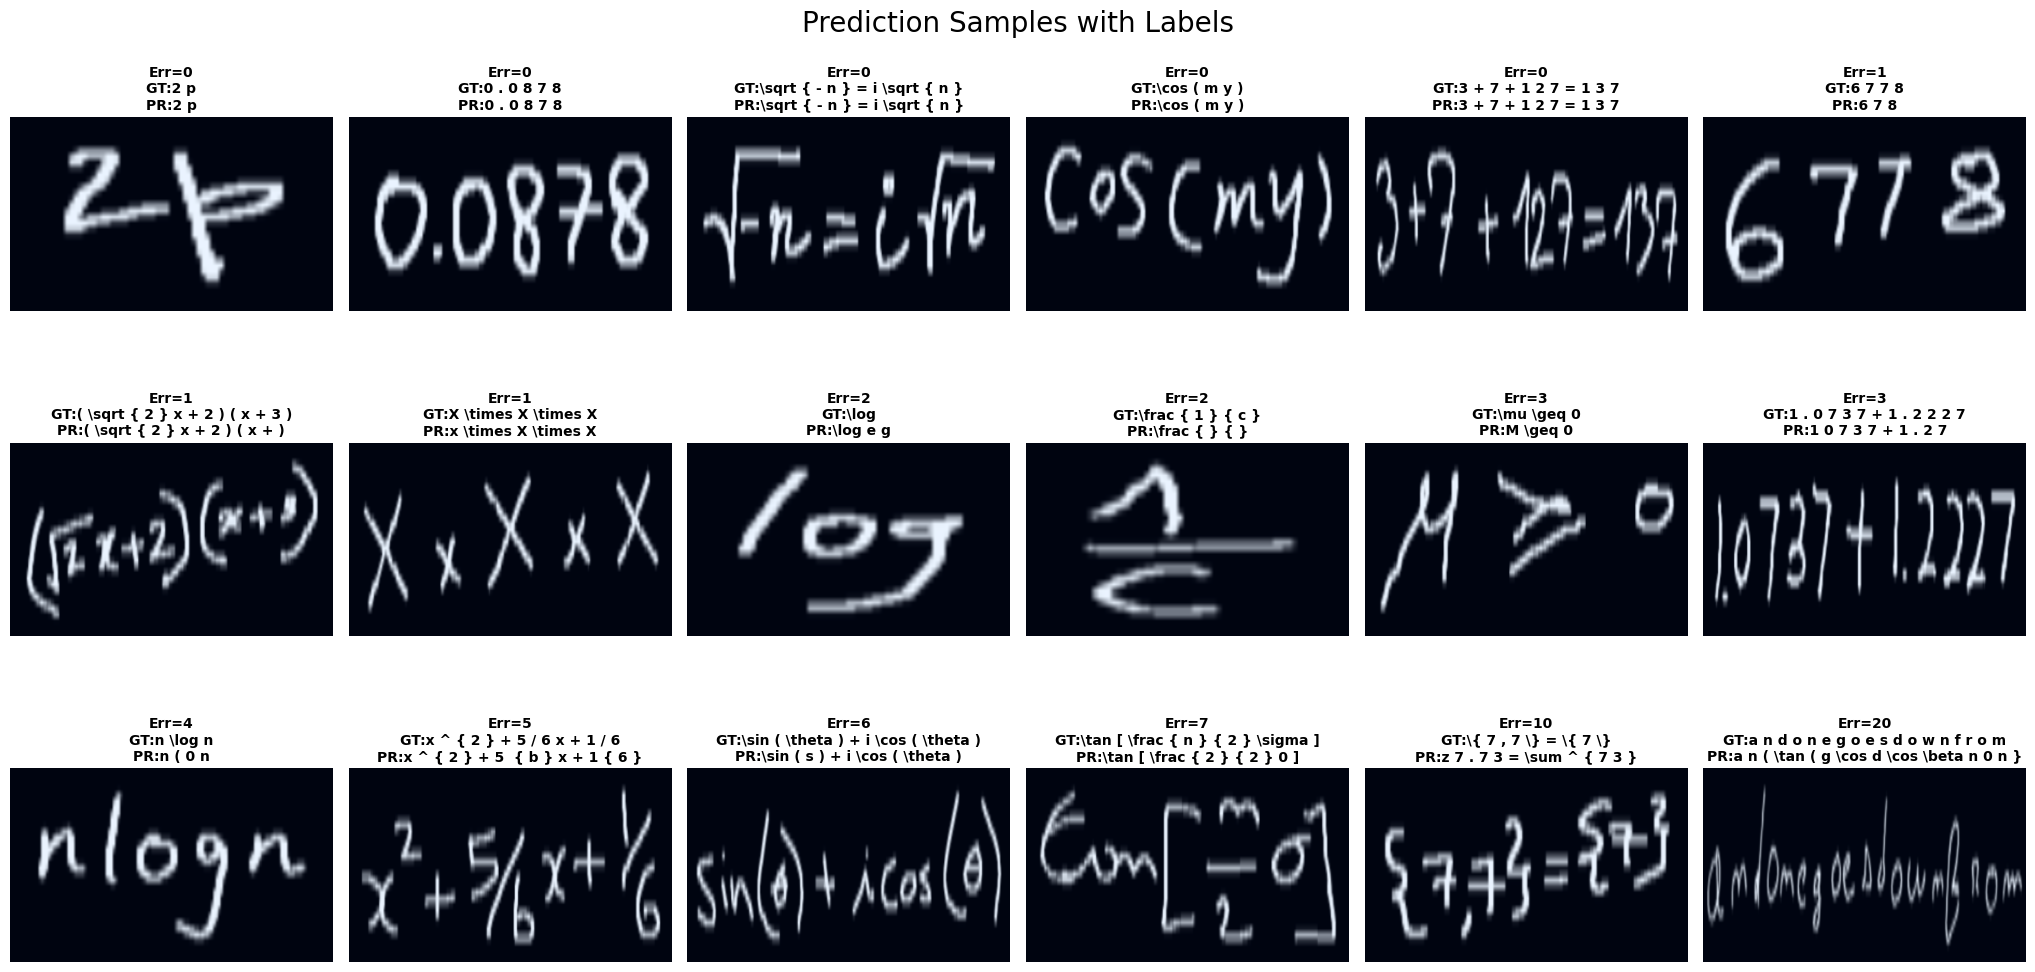

In [27]:
samples = select_diverse_error_samples(entries, n=18)
plot_grid_of_predictions(
    samples,
    title="Prediction Samples with Labels",
    max_label_length=40  # Only plot if GT and PR are short enough
)


In [28]:
import pandas as pd
import csv

def save_predictions_to_csv(entries, save_path):
    data = []
    for img, true, pred, err, confs in entries:
        data.append({
            "GroundTruth": true,
            "Prediction": pred,
            "Error": err,
            "TokenConfidences": " ".join([f"{c:.2f}" for c in confs])
        })
    df = pd.DataFrame(data)
    df.to_csv(save_path, index=False, quoting=csv.QUOTE_MINIMAL)
    print(f"✅ Saved {len(df)} entries to {save_path}")


In [29]:
save_predictions_to_csv(entries, save_path="predictions.csv")
save_predictions_to_csv(test_entries, save_path='test_prediction.csv')

✅ Saved 2185 entries to predictions.csv
✅ Saved 1147 entries to test_prediction.csv


In [30]:
def postprocess_prediction_based_on_gt(pred, gt):
    if '|' in gt:
        return pred  # preserve bars if they are expected
    else:
        # Remove all standalone '|' tokens
        tokens = pred.split()
        cleaned_tokens = [tok for tok in tokens if tok != '|']
        return " ".join(cleaned_tokens)

# Load predictions CSV
df = pd.read_csv("predictions.csv")
df_test = pd.read_csv('test_prediction.csv')

# Apply post-processing
# Ensure predictions and ground truths are strings
df = df.dropna(subset=["Prediction", "GroundTruth"]).copy()
df_test = df_test.dropna(subset=["Prediction", "GroundTruth"]).copy()

# Apply post-processing safely
df["Prediction_Cleaned"] = [
    postprocess_prediction_based_on_gt(str(pred), str(gt))
    for pred, gt in zip(df["Prediction"], df["GroundTruth"])
]
df_test["Prediction_Cleaned"] = [
    postprocess_prediction_based_on_gt(str(pred), str(gt))
    for pred, gt in zip(df_test["Prediction"], df_test["GroundTruth"])
]

# Save cleaned results
df.to_csv("predictions_cleaned.csv", index=False)
df_test.to_csv("test_predictions_cleaned.csv", index=False)
print("✅ Cleaned predictions saved to prediction_cleaned.csv and test_predictions_cleaned.csv")

✅ Cleaned predictions saved to prediction_cleaned.csv and test_predictions_cleaned.csv


In [31]:
cleaned_preds = df_test["Prediction_Cleaned"].tolist()
ground_truths = df_test["GroundTruth"].astype(str).tolist()

cleaned_wer = compute_wer(cleaned_preds, ground_truths)
cleaned_cer = compute_cer(cleaned_preds, ground_truths)

print(f"✅ Cleaned WER: {cleaned_wer:.4f}")
print(f"✅ Cleaned CER: {cleaned_cer:.4f}")

✅ Cleaned WER: 0.3807
✅ Cleaned CER: 0.3419


In [32]:
# Load predictions
df = pd.read_csv("predictions.csv")

# Drop rows with missing predictions or ground truths
df = df.dropna(subset=["Prediction", "GroundTruth"]).copy()

# Convert all to strings to be safe
original_preds = df["Prediction"].astype(str).tolist()
ground_truths = df["GroundTruth"].astype(str).tolist()

# Compute WER and CER
original_wer = compute_wer(original_preds, ground_truths)
original_cer = compute_cer(original_preds, ground_truths)

print(f"📊 Original WER: {original_wer:.4f}")
print(f"📊 Original CER: {original_cer:.4f}")


📊 Original WER: 0.3733
📊 Original CER: 0.3253


In [33]:
# Extract original predictions and ground truths
original_preds = df["Prediction"].tolist()
ground_truths = df["GroundTruth"].tolist()

# Token lengths of ground truths
lengths = [len(gt.split()) for gt in ground_truths]
short_threshold = np.median(lengths)

# Indices for short and long expressions
short_indices = [i for i, l in enumerate(lengths) if l <= short_threshold]
long_indices  = [i for i, l in enumerate(lengths) if l > short_threshold]

# ----------------------
# ORIGINAL (UNCLEANED) WER
# ----------------------
original_short_preds = [original_preds[i] for i in short_indices]
original_short_gts   = [ground_truths[i] for i in short_indices]

original_long_preds  = [original_preds[i] for i in long_indices]
original_long_gts    = [ground_truths[i] for i in long_indices]

original_short_wer = compute_wer(original_short_preds, original_short_gts)
original_long_wer  = compute_wer(original_long_preds, original_long_gts)

print(f"\n🧪 Original WER (Short expressions): {original_short_wer:.4f}")
print(f"🧪 Original WER (Long expressions):  {original_long_wer:.4f}")

# ----------------------
# CLEANED WER
# ----------------------
df["Prediction_Cleaned"] = [
    postprocess_prediction_based_on_gt(pred, gt)
    for pred, gt in zip(original_preds, ground_truths)
]

cleaned_preds = df["Prediction_Cleaned"].tolist()

cleaned_short_preds = [cleaned_preds[i] for i in short_indices]
cleaned_short_gts   = [ground_truths[i] for i in short_indices]

cleaned_long_preds  = [cleaned_preds[i] for i in long_indices]
cleaned_long_gts    = [ground_truths[i] for i in long_indices]

cleaned_short_wer = compute_wer(cleaned_short_preds, cleaned_short_gts)
cleaned_long_wer  = compute_wer(cleaned_long_preds, cleaned_long_gts)

print(f"\n✅ Cleaned WER (Short expressions): {cleaned_short_wer:.4f}")
print(f"✅ Cleaned WER (Long expressions):  {cleaned_long_wer:.4f}")
print(f"📊 Threshold used to split short/long: {short_threshold:.0f} tokens")



🧪 Original WER (Short expressions): 0.2580
🧪 Original WER (Long expressions):  0.4084

✅ Cleaned WER (Short expressions): 0.2579
✅ Cleaned WER (Long expressions):  0.4084
📊 Threshold used to split short/long: 14 tokens
